In [1]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc as misc
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2 as cv2
%matplotlib inline

In [6]:
files = glob.glob("sample_dataset/*.jpg")
print("There are {} images".format(len(files)))
df = pd.DataFrame(files, columns=["file"])
df.head()
df["steer"] = df["file"].replace(to_replace="(.*)?leftimage_", value="", regex=True)
df["steer"] = df["steer"].replace(to_replace=".jpg", value="", regex=True)
df["steer"] = pd.to_numeric(df["steer"])
print(df.dtypes)
df.head()
df.shape

There are 25 images
file      object
steer    float64
dtype: object


(25, 2)

sample_dataset/0.0782-leftimage_0.0.jpg
(376, 672, 3)


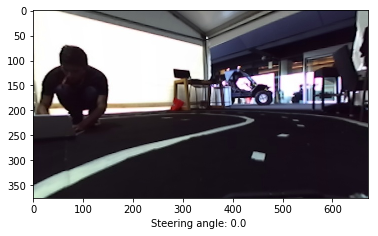

In [7]:
def show_image(index):
    print(df['file'][index])
    image = mpimg.imread(df['file'][index])
    print(image.shape)
    plt.imshow(image)
    plt.xlabel("Steering angle: {} ".format(df['steer'][index]))

show_image(5)

In [8]:
def shuffle_images(df): 
    mask = df["steer"] == 0
    zeros = df[mask]
    nonzeros = df[mask==False]
    sample_size = int(zeros.shape[0]*0.10)
    zero_sample = zeros.sample(n=sample_size)
    
    return zero_sample.append(nonzeros).sample(frac=1).reset_index(drop=True)

sample = shuffle_images(df)
print(sample.shape[0])

18


(25, 44, 168, 3)
(25, 1)
[[-0.18421935]
 [ 0.        ]
 [ 0.13819683]
 [ 0.14882466]
 [ 0.        ]]


(array([2., 2., 1., 2., 1., 9., 1., 2., 2., 3.]),
 array([-0.27981749, -0.22491573, -0.17001396, -0.1151122 , -0.06021044,
        -0.00530867,  0.04959309,  0.10449485,  0.15939662,  0.21429838,
         0.26920015]),
 <a list of 10 Patch objects>)

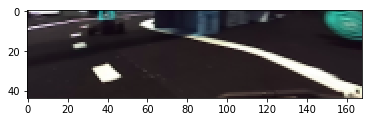

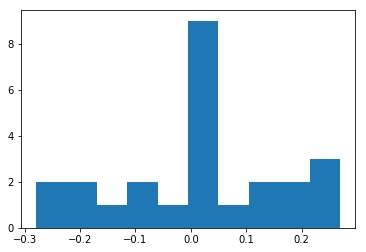

In [9]:
def get_images(df): 
    result = [] 
    for path in df["file"]:
        try:
            img = cv2.imread(path)
            img = img[200:, :]
    #         img = misc.imresize(img, (113,168))
            img = cv2.resize(img, (168, 44), interpolation=cv2.INTER_AREA)
            result.append(img)
        except: 
            print(path)
            continue
    return np.stack(result)

x = get_images(df)
print(x.shape)
y = df.as_matrix(columns=['steer'])
plt.imshow(x[0])
print(y.shape)
print(y[10:15])
plt.figure()
plt.hist(y)

In [14]:
# TODO: Build a model
import keras
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Input
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization
from keras.regularizers import l2

def Nvidia():
    model = Sequential()
#     model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))
    model.add(Conv2D(24, (3, 3), strides=(2, 2), padding="same", activation="relu", input_shape=(44,168,3)))
    model.add(BatchNormalization(axis=-1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(36, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=-1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(48, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=-1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=-1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=-1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    model.add(Dense(125, activation="relu"))
    model.add(Dense(25, activation="relu"))
    model.add(Dense(1))
    adam = Adam(lr=0.001)
    model.compile(adam, 'mae')
    return model

model = Nvidia()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 22, 84, 24)        672       
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 84, 24)        96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 84, 24)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 42, 36)        7812      
_________________________________________________________________
batch_normalization_6 (Batch (None, 11, 42, 36)        144       
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 42, 36)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 21, 48)         15600     
__________

In [ ]:
import random
import scipy.ndimage as ndi

def trans_image(image,steer):
    # Translation
    scale = np.random.normal(loc=0.0, scale=.5)
    steer_ang = steer + 0.1 * scale
    tx = 0
    ty = 100 * scale

    translation_matrix = np.float32([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1 ]])
#     image_tr = cv.warpAffine(image,translation_matrix,(image.shape[1],image.shape[0]))
    image_tr = apply_transform(image, translation_matrix)
    
    steer_ang = max(-0.34, steer_ang)
    steer_ang = min(0.34, steer_ang)
    
    return image_tr,steer_ang

def apply_transform(x,
                    transform_matrix,
                    channel_axis=2,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.
    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    toobright = image1[:,:,2] > 255/random_bright
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][toobright] = 255
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def crop_resize(img):
    img = img[200:, :]
#     img = cv.cvtColor(img, cv.COLOR_RGB2YUV)
    img = cv2.resize(img, (168, 44), interpolation=cv2.INTER_AREA)
    return img

def preprocess_img(row):
    img = None
    steering = None
    steering = row['steer']
        
    img = cv2.imread(row["file"])
    img, steering = trans_image(img, steering)
    img = crop_resize(img)
    
    # randomly adjust brightness 
    img = augment_brightness_camera_images(img)
    
    #random flip
    flip = random.randint(0, 1)
    if flip == 1: 
        img = np.fliplr(img)
        steering = -steering
    
    return img, steering

img, steering = preprocess_img(df.iloc[0])
print(steering)
plt.imshow(img)

In [ ]:
img, steering = preprocess_img(df.iloc[0])
print(steering)
plt.imshow(img)

In [ ]:
## instead of above, and just plain training, let's use a generator to help randomly augment data

# df = df[(df['steering'] <= -0.01) | (df['steering'] >= 0.01)].reset_index(drop=True)

import sklearn
import cv2 as cv2
def generator(df, batch_size=256):
    
    while 1: # Loop forever so the generator never terminates
        x_sample = []
        y_sample = []
        pr_threshold = 1
        for i in range(batch_size):
            index = np.random.randint(len(df))
            row = df.iloc[index]
            image, steering = preprocess_img(row)
#             keep_pr = 0
#             while keep_pr == 0:
#                 image, steering = preprocess_img(row)
#                 pr_unif = np.random
#                 if abs(steering)<.001:
#                     pr_val = np.random.uniform()
#                     if pr_val>pr_threshold:
#                         keep_pr = 1
#                 else:
#                     keep_pr = 1
#             pr_threshold = 0.995 * pr_threshold
            x_sample.append(image)
            y_sample.append(steering)
        yield np.stack(x_sample), np.asarray(y_sample).reshape(batch_size, 1)
#         pr_threshold = 0.90 * pr_threshold

sample = shuffle_images(df)
train_generator = generator(sample)
validation_generator = generator(df)

In [ ]:
# testing distribution
test_y = [next(train_generator)[1] for i in range(5)]
test_y = np.vstack(test_y)

plt.figure(figsize=(20,10))
plt.hist(test_y, bins=20)
# this will shuffle a dataframe df.sample(frac=1).reset_index(drop=True)

In [ ]:
for i in range(20):
    sample = shuffle_images(df)
    train_generator = generator(sample)
    model.optimizer.lr.assign(0.01)
    history = model.fit_generator(train_generator, steps_per_epoch=10, epochs=10, verbose=1)

In [ ]:
### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
model.save('./driving_net_model.h5')
model.save_weights("./driving_net_weights.h5")

In [ ]:
model.save('./driving_net_shift_model.h5')
model.save_weights("./driving_net_shift_weights.h5")

In [ ]:
from keras.models import load_model
model = load_model('./driving_net_shift_model.h5')

In [ ]:
import random

# x, y = next(generator(df))

diff = []
for i in range(1, 10):
    test_index=random.randint(0, len(df))
#     print(test_index)
    test_image = cv2.imread(df['file'][test_index])
    test_image = crop_resize(test_image)
    y  = df['steer'][test_index]
    %timeit prediction = model.predict(test_image[None, :, :, :], batch_size=1)[0][0]
    diff.append(prediction - y)
    plt.figure()
    plt.imshow(test_image)
    plt.title("".join(["index:", str(test_index), " actual: ", str(y), " prediction:", str(prediction)
                        , " diff:", str(prediction - y)]))
#     print("index:", test_index, " actual: ", y, " prediction:", prediction, " diff:", prediction - y)

print("std: ", np.array(diff).std())

   # Smaller CNN

In [13]:
import keras
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Input
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization
from keras.regularizers import l2

def Nvidia():
    model = Sequential()
#     model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))
    model.add(Conv2D(12, (3, 3), strides=(2, 2), padding="same", activation="relu", input_shape=(44,168,3)))
    model.add(BatchNormalization(axis=-1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(18, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=-1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(24, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(30, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(36, (3, 3), strides=(1, 1), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(250, activation="relu"))
    model.add(Dense(40, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    adam = Adam(lr=0.001)
    model.compile(adam, 'mae')
    return model

model = Nvidia()
model.summary()

ValueError: Shape must be rank 1 but is rank 0 for 'batch_normalization_4/cond/Reshape_4' (op: 'Reshape') with input shapes: [1,11,1,1], [].

# Dilated Convolutional Neural Net

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Input
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization
from keras.regularizers import l2

def Dilated():
    model = Sequential()
#     model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))
    model.add(Conv2D(12, (3, 3), strides=(2, 2), padding="same", activation="relu", input_shape=(44,168,3)))
#     model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(12, (3, 3), strides=(1, 1), dilation_rate=(2,2), padding="same", activation="relu"))
#     model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(18, (3, 3), strides=(4, 4), dilation_rate=(1,1), padding="same", activation="relu"))
#     model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(18, (3, 3), strides=(1, 1), dilation_rate=(4,4), padding="same", activation="relu"))
#     model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(24, (3, 3), strides=(2, 2), padding="same", activation="relu"))
#     model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(48, (3, 3), strides=(1, 1), padding="same", activation="relu"))
#     model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
# #     model.add(Dropout(0.2))
#     model.add(Conv2D(48, (3, 3), strides=(2, 2), padding="same", activation="relu"))
#     model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(150, activation="relu"))
    model.add(Dense(30, activation="relu"))
    model.add(Dense(1))
    adam = Adam(lr=0.001)
    model.compile(adam, 'mae')
    return model

model = Dilated()
model.summary()

In [ ]:
for i in range(40):
    sample = shuffle_images(df)
    train_generator = generator(sample)
    model.optimizer.lr.assign(0.01)
    history = model.fit_generator(train_generator, steps_per_epoch=10, epochs=10, verbose=1)

In [ ]:
model.save('./driving_net_dilated_model.h5')
model.save_weights("./driving_net_dilated_weights.h5")

In [ ]:
import random

# x, y = next(generator(df))

diff = []
for i in range(1, 10):
    test_index=random.randint(0, len(df))
#     print(test_index)
    test_image = cv2.imread(df['file'][test_index])
    test_image = crop_resize(test_image)
    y  = df['steer'][test_index]
    %time prediction = model.predict(test_image[None, :, :, :], batch_size=1)[0][0]
    diff.append(prediction - y)
    plt.figure()
    plt.imshow(test_image)
    plt.title("".join(["index:", str(test_index), " actual: ", str(y), " prediction:", str(prediction)
                        , " diff:", str(prediction - y)]))
#     print("index:", test_index, " actual: ", y, " prediction:", prediction, " diff:", prediction - y)

print("std: ", np.array(diff).std())